## Setup

Two options: `read_csv` from `customers_normal.csv` for a 4 function data frame and visualization focused on clarity. `read` from `customers_plus.csv` for an additional step in complexity with the addition of two features (doctorate, city density).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# import DBSCAN
from sklearn.cluster import DBSCAN
from itertools import product

In [2]:
#import normalized data
customers_normal = pd.read_csv('data_imgs/customers_normal.csv')
customers_normal.head()

,income,age,gender,marital_status
0,0.107091,0.120215,-1.125463,0.086460
1,-0.775606,1.468102,-1.125463,0.086460
2,-0.236233,-0.311109,0.888523,-1.035942
3,1.078893,0.551539,0.888523,-1.035942
4,0.938258,0.821116,0.888523,2.331263


### Visualizing data

Text(0, 0.5, 'Income')

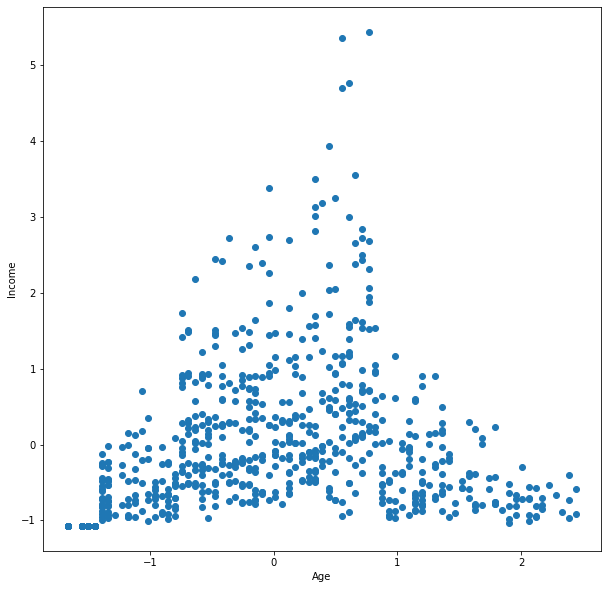

In [3]:
#sample plot
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(customers_normal.age, customers_normal.income)
ax.set_xlabel('Age')
ax.set_ylabel('Income')

## Sample

In [4]:
age_income = np.asarray(customers_normal.loc[:,['income', 'age']])
age_income

array([[ 0.10709118,  0.12021489],
       [-0.77560585,  1.4681017 ],
       [-0.23623257, -0.31110889],
       ...,
       [ 1.69454581,  0.33587678],
       [-0.39195216, -0.36502436],
       [-0.2666268 , -1.38941833]])

In [5]:
#custom function for creating graphs of different combinations
def DBSCAN_test(data, combination, graph_number):
    """Number of figs (subplot rows * subplot columns) must equal combos length for proper mapping
    figsize should be a list with two integers
    data and combos should be nparrays, data with two elements
    
    df = np.array([1, 2, 3, 4], [3, 4, 5, 6])
    combination = np.array([0.1, 0.1], [0.1, 1], [0.1, 20], [5, 0.1], [5, 1], [5, 20])
    dimension = math.sqrt(len(combination))
    ex: DBSCAN_test(df, combination, [dimension, dimension])
            --> output: supblot visual of input shape with DBSCAN outcomes plotted 
            for each combination
    """
    
    fig, axes = plt.subplots(graph_number[0], graph_number[1], figsize=(12, 12))
    fig.tight_layout()

    # Plot the data using one of Matplotlib's plotting functions
    for i in range(len(combination)):
        db = DBSCAN(eps=combination[i][0],
                    min_samples=combination[i][1],
                    metric='euclidean')
        
        data_db = db.fit_predict(data)

        # Plot the data using one of Matplotlib's plotting functions
         #create empty centroid lists
        X_centroids = []
        Y_centroids = []
    
        #append each new cluster mean for each iteration
        for cluster in set(data_db):
            x = data[data_db == cluster,0]
            y = data[data_db == cluster,1]
            X_centroids.append(np.mean(x))
            Y_centroids.append(np.mean(y))
        
            #visualize    
            axes.flat[i].scatter(x, y, s=50, marker='s', label=f"cluster {cluster}")
            axes.flat[i].set_title(combos[i])

In [6]:
#defining parameters
eps = [0.2, 0.3]
min_samples = [5, 7, 10, 12]
#making combinations
combos = list(product(eps, min_samples))
len(combos) #in this case it's 8

8

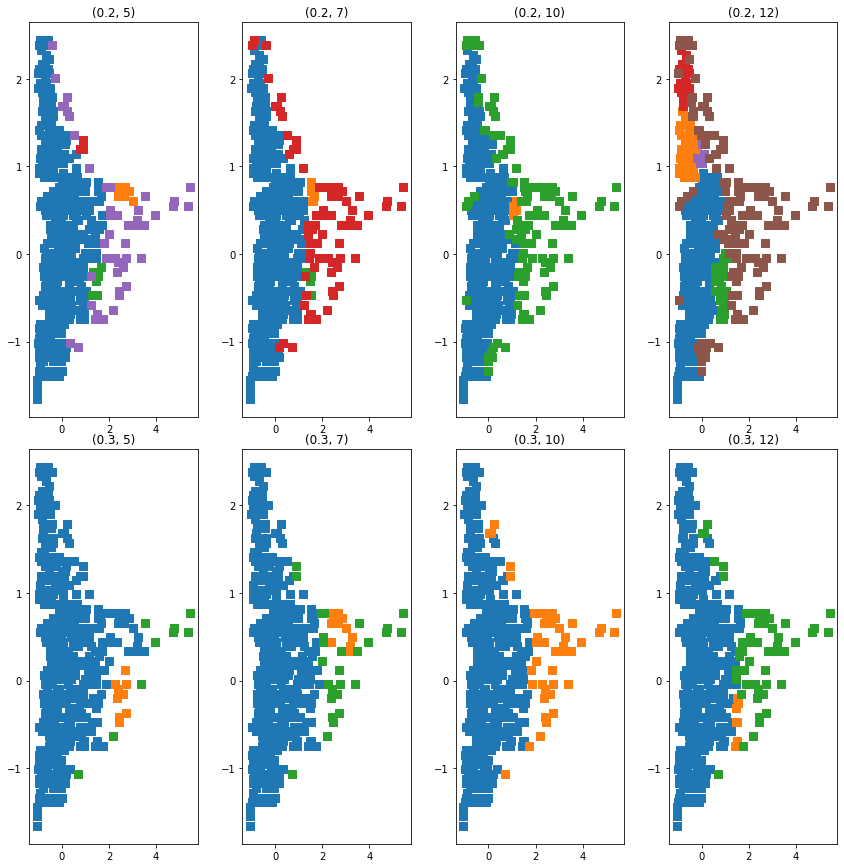

In [7]:
DBSCAN_test(age_income, combos, [2, 4]) 

## Radar Chart

In [8]:
def radar_plot(data, cluster, 
               title = "Clustering", 
               save=False, 
               cluster_map=False):
    """Creates a radar plot from inputed data and clustering model output
    data should be DataFrame and cluster an np.array
    
    title can be specified to set plot title or it will default to 'Clustering'
    
    save can be specified as a string in which case the image is saved to the path
    of that inputted string. If no string is specified the image will not be saved.
    
    cluster_map specifies how many of the identified clusters to draw. 
    Must be integer > 0
    """
    
    #concatinate clustering and data
    data_cluster = pd.concat([data,pd.DataFrame(cluster)], axis=1)
    data_cluster = data_cluster.rename(columns= {0: 'cluster'})
    #group by cluster with means and save to new frame
    clustered = data_cluster.groupby('cluster').median()
    #generate category labels
    categories = [*clustered.columns, clustered.columns[0]]

    #empty object for defining groups
    radar = []
    #define groups, last element must be first element to close radar group
    for i in range(len(clustered)):
        radar.append([*clustered.iloc[i], clustered.iloc[i, 0]])
    
    #label location for radar plot
    label_loc = np.linspace(start=0, stop=2 * np.pi, 
                            num=len(radar[0]))
    #color scheme
    colors = ['royalblue', 'darkorange', 'forestgreen', 'sienna', 'mediumpurple']  
    
    #initiate plot
    plt.figure(figsize=(8,8))
    plt.subplot(polar = True)
    
    #if cluster map is defined
    if bool(cluster_map):
        cluster_map = cluster_map
    else:
        cluster_map = len(radar)
    
    #loop through every cluster
    for i in range(0,cluster_map):
        #if there are outliers (ex with DBSCAN) id them
        if clustered.index[i] < 0:
            plt.plot(label_loc, radar[i], label=f"Outliers", color='red')
        #else plot as cluster
        else: 
            plt.plot(label_loc, radar[i], label=f"Cluster {i}", color=colors[i])
    
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)

    plt.title(title)
    plt.legend()
    
    #if save path is defined save figure
    if bool(save):
        plt.savefig(save)
    #if not just show
    else:
        plt.show()

#### DBSCAN

In [9]:
db = DBSCAN(eps=1.3,
            min_samples=15,
            metric='euclidean')

y_db = db.fit_predict(customers_normal.values)
#length of db should correspond with customer row #
len(y_db), customers_normal.shape

(714, (714, 4))

-1      8
 0    310
 1    396
dtype: int64


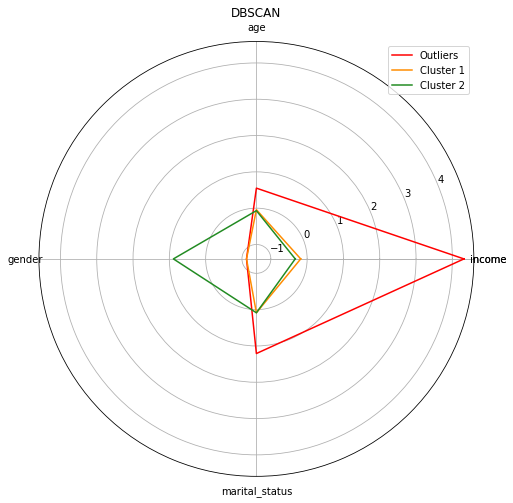

In [10]:
print(pd.DataFrame(y_db).value_counts().sort_index())
radar_plot(customers_normal, y_db, 'DBSCAN', 'data_imgs/normal_DBSCAN.png')

#### Hierarchy Cluster

In [11]:
#import needed libraries
from sklearn.cluster import AgglomerativeClustering

#cluster hierarchy
import scipy.cluster.hierarchy as sch

In [12]:
#let's plot the dendrogram
def plot_dendrogram(X, method='ward'):
   #let's plot the data we just generated
    fig, ax = plt.subplots(figsize=(12,8))

    dendrogram = sch.dendrogram(sch.linkage(X, method=method))
    plt.title("Dendrogram")
    plt.ylabel("Euclidean distances")
    plt.xlabel('Points')
    plt.show()

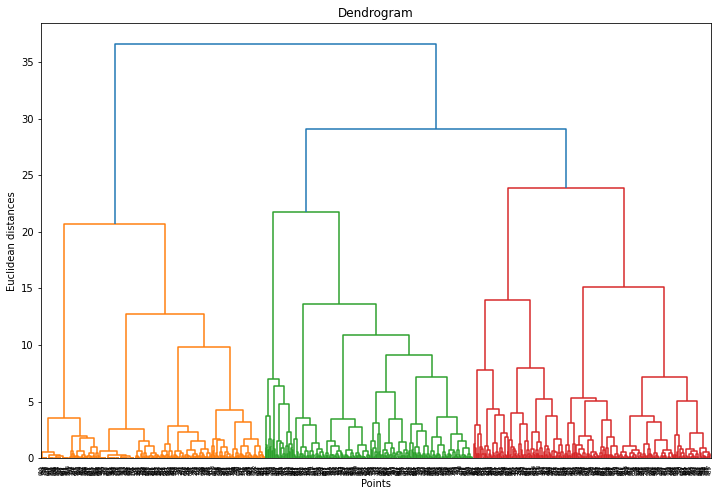

In [13]:
#run function
plot_dendrogram(customers_normal.values)

In [14]:
#create an agglomerative object defining linkage
ac = AgglomerativeClustering(affinity='euclidean',
                             linkage='ward',
                             n_clusters=5)
#fit and predict
y_hc = ac.fit_predict(customers_normal.values)

0    239
1     97
2    156
3    192
4     30
dtype: int64


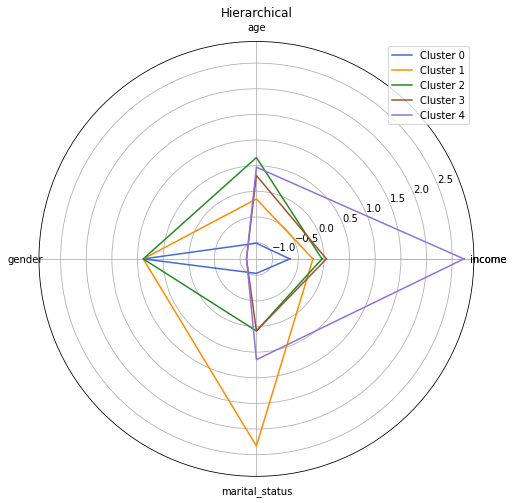

In [15]:
print(pd.DataFrame(y_hc).value_counts().sort_index())
radar_plot(customers_normal, y_hc, 'Hierarchical', 'data_imgs/normal_hierarchy.png')

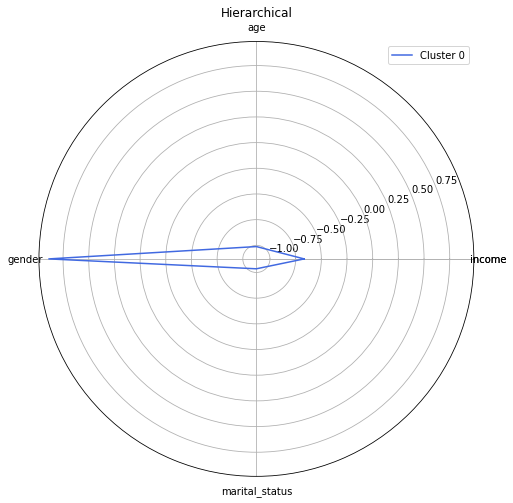

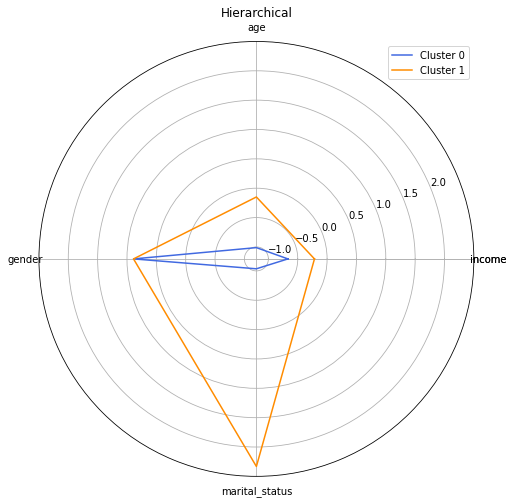

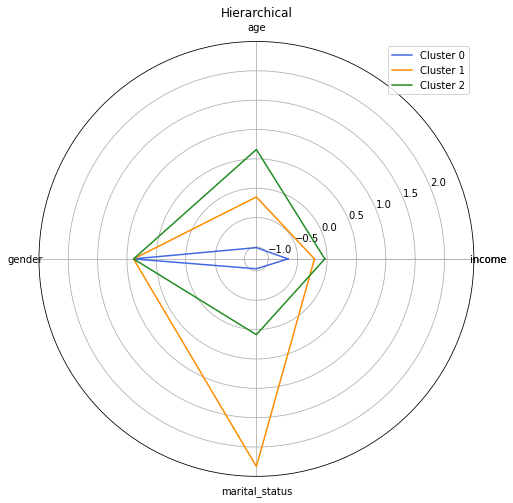

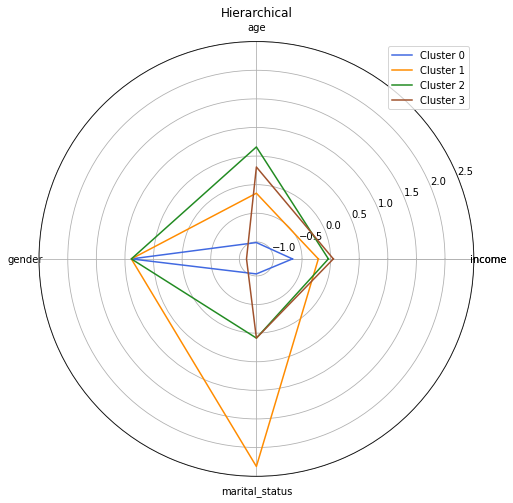

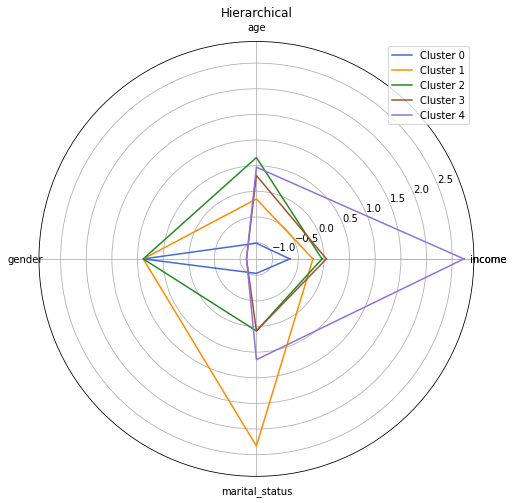

In [16]:
for i in range(1, 6):
    path = f"data_imgs/hierarchy_step{i}"
    radar_plot(customers_normal, y_hc, 'Hierarchical', path, i)

#### K-means

In [17]:
#import
from sklearn.cluster import KMeans

In [18]:
#function to calculate distortion for multiple k values and plot the result
def plot_distortion(X, max_clusters = 10):
    #empty object to distore distortion
    distortions = []
    
    #iterate through each number, initialize and run kmeans, append distortion
    for i in range(1, max_clusters+1):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    random_state=0)
        km.fit(X)
        #.inertia_ attribute retrieves distortions
        distortions.append(km.inertia_)
    
    #visualize
    plt.plot(range(1, max_clusters+1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')  
    plt.show()

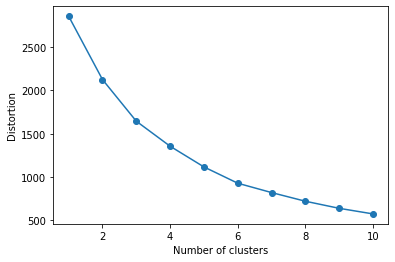

In [19]:
#run function with generated data
plot_distortion(customers_normal, max_clusters=10) 

In [20]:
#initialize KMeans
km = KMeans(n_clusters=5, n_init=10, random_state=0)
#fit and predict
y_km = km.fit_predict(customers_normal)

0    239
3    192
2    156
1     97
4     30
dtype: int64


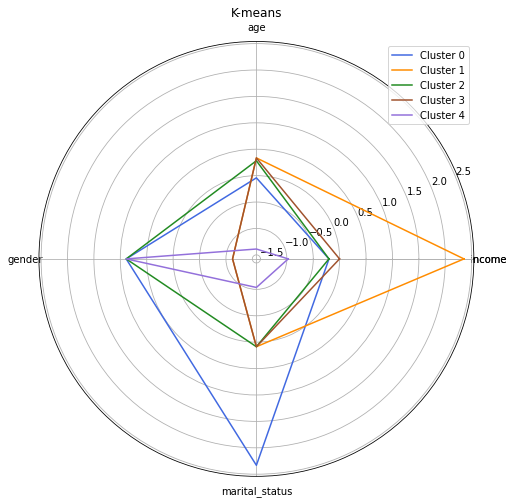

In [21]:
print(pd.DataFrame(y_hc).value_counts())
radar_plot(customers_normal, y_km, 'K-means', 'data_imgs/normal_kmeans.png')

## PCA

In [22]:
from sklearn.decomposition import PCA

In [23]:
# Applying the PCA to the original dataset
pca = PCA() #Instatiating

pca.fit(customers_normal)

customers_pca = pca.transform(customers_normal)

#set empty columns
columns = []
#for each PC generated create a label with the relevent number
for i in range(customers_pca.shape[1]):
    PC = f"PC{i}"
    #append to columns object
    columns.append(PC)
    
pca_df = pd.DataFrame(customers_pca, columns = columns)

pca.explained_variance_ratio_ #automatically generates 5 pretty large weights

array([0.37036591, 0.26405629, 0.19030607, 0.17527174])

In [24]:
#just take first two for visualization purposes
pca = PCA(n_components = 2) #Instatiating

pca.fit(customers_normal)

pca_2 = pca.transform(customers_normal)
pca2_df = pd.DataFrame(pca_2, columns = ['PC1', 'PC2'])
pca.explained_variance_ratio_ #automatically generates 5 pretty large weights

array([0.37036591, 0.26405629])

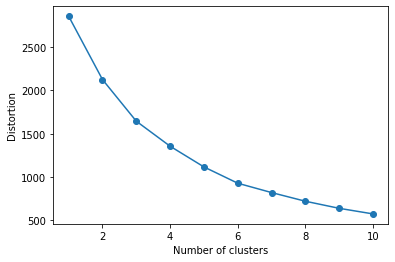

In [25]:
#elbow function
plot_distortion(customers_pca, max_clusters=10) #7?

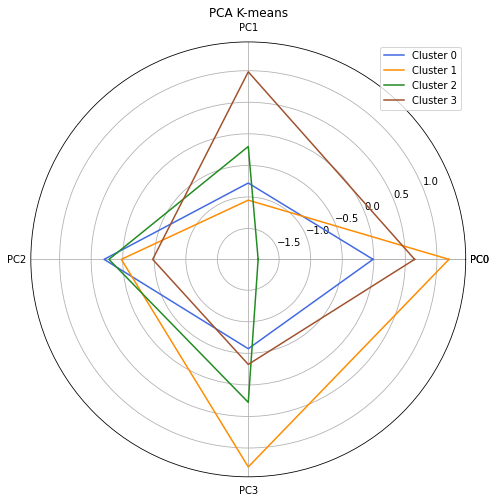

In [26]:
#initialize KMeans
km = KMeans(n_clusters=4, n_init=10, random_state=0)
#fit and predict
y_km = km.fit_predict(customers_pca)
radar_plot(pca_df, y_km, 'PCA K-means')

In [27]:
#now lets try DBSCAN
db = DBSCAN(eps=1.2,
            min_samples=20,
            metric='euclidean')

y_db = db.fit_predict(pca_df.values)

pd.DataFrame(y_db, columns=['cluster']).value_counts('cluster')

cluster
 1    391
 0    290
-1     33
dtype: int64

In [28]:
#create an agglomerative object defining linkage
ac = AgglomerativeClustering(affinity='euclidean',
                             linkage='ward',
                             n_clusters=4)
#fit and predict
y_hc = ac.fit_predict(pca_df.values)

In [29]:
compare_pca = pd.concat([pca2_df,
           pd.DataFrame(y_km, columns=['kmeans']),
           pd.DataFrame(y_db, columns=['dbscan']),
           pd.DataFrame(y_hc, columns=['heirarchy'])],
          axis=1)
compare_pca.head()

,PC1,PC2,kmeans,dbscan,heirarchy
0,0.376843,0.942408,3,0,0
1,0.676335,0.279159,3,0,0
2,-1.072877,-0.458904,0,1,1
3,0.133860,-0.272043,0,1,1
4,2.193026,-1.346723,1,1,3


kmeans
0    250
3    210
2    157
1     97
dtype: int64

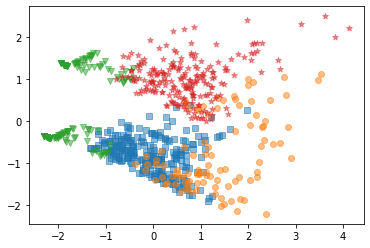

In [30]:
fig, ax = plt.subplots()
markers = ['s', 'o', 'v', '*', '+']

for i in np.unique(y_km): 
    ax.scatter(pca2_df.loc[compare_pca['kmeans'] == i, 'PC1'], 
               pca2_df.loc[compare_pca['kmeans'] == i, 'PC2'], 
               marker=markers[i], alpha = 0.5)
compare_pca.value_counts('kmeans')

dbscan
 1    391
 0    290
-1     33
dtype: int64

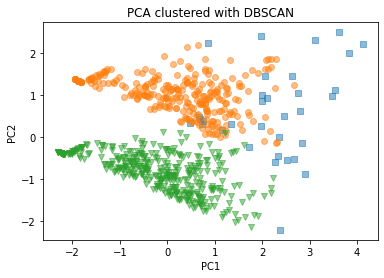

In [31]:
fig, ax = plt.subplots()

for i in range(len(np.unique(y_db))): 
    ax.scatter(pca2_df.loc[compare_pca['dbscan'] == np.unique(y_db)[i], 'PC1'], 
               pca2_df.loc[compare_pca['dbscan'] == np.unique(y_db)[i], 'PC2'], 
               marker=markers[i], alpha = 0.5)

ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_title('PCA clustered with DBSCAN')
plt.savefig('data_imgs/PCA_DBSCAN.png')
compare_pca.value_counts('dbscan')

heirarchy
1    239
0    222
2    156
3     97
dtype: int64

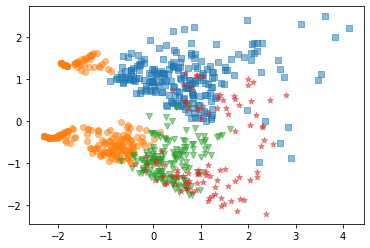

In [32]:
fig, ax = plt.subplots()

for i in range(len(np.unique(y_hc))): 
    ax.scatter(pca2_df.loc[compare_pca['heirarchy'] == np.unique(y_hc)[i], 'PC1'], 
               pca2_df.loc[compare_pca['heirarchy'] == np.unique(y_hc)[i], 'PC2'], 
               marker=markers[i], alpha = 0.5)
    
compare_pca.value_counts('heirarchy')

## Misc

### Data Subsets

Using the tools I've developped let's generate explore different feature inputs

In [33]:
#different data
trifecta = customers_normal[['income', 'age', 'gender']]
personal = customers_normal[['age', 'gender', 'marital_status']]

labels = ['trifecta', 'personal']
different_data = [trifecta, personal]

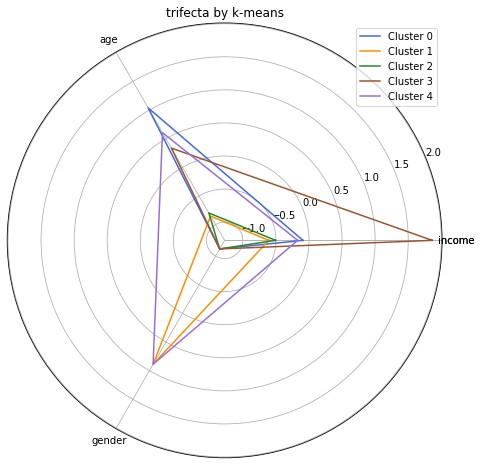

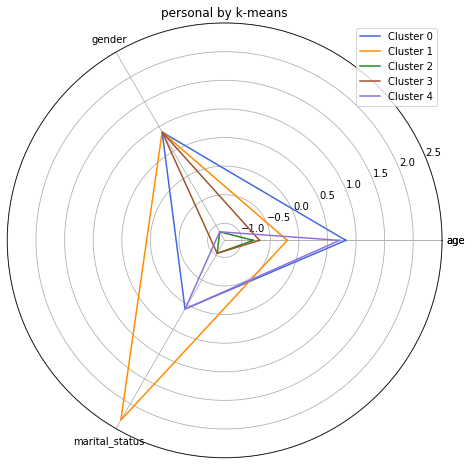

In [34]:
for i in range(len(different_data)):
    #initialize KMeans
    km = KMeans(n_clusters=5, n_init=10, random_state=0)
    #fit and predict
    y_km = km.fit_predict(different_data[i])
    
    radar_plot(different_data[i], y_km, f"{str(labels[i])} by k-means")

0    256
2    232
1    226
dtype: int64


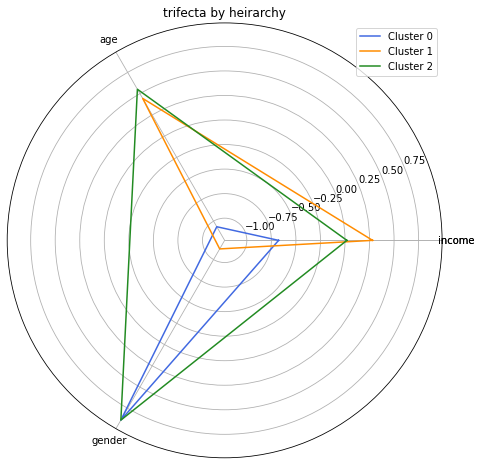

0    329
1    267
2    118
dtype: int64


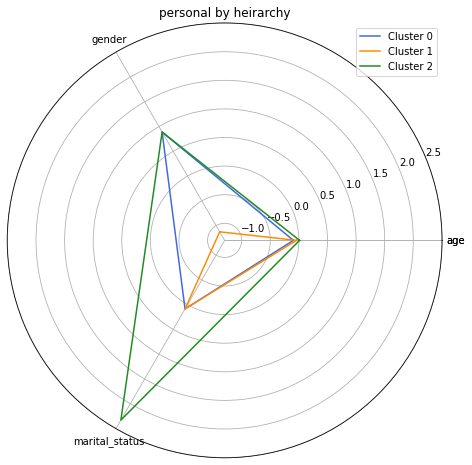

In [35]:
n_clusters = [3, 3, 4] #used dendrograms

for i in range(len(different_data)):
    #initialize KMeans
    hc = AgglomerativeClustering(affinity='euclidean',
                             linkage='ward',
                             n_clusters=n_clusters[i])
    #fit and predict
    y_hc = hc.fit_predict(different_data[i])
    print(pd.DataFrame(y_hc).value_counts())
    radar_plot(different_data[i], y_hc, f"{str(labels[i])} by heirarchy")
    

 1    392
 0    310
-1     12
dtype: int64


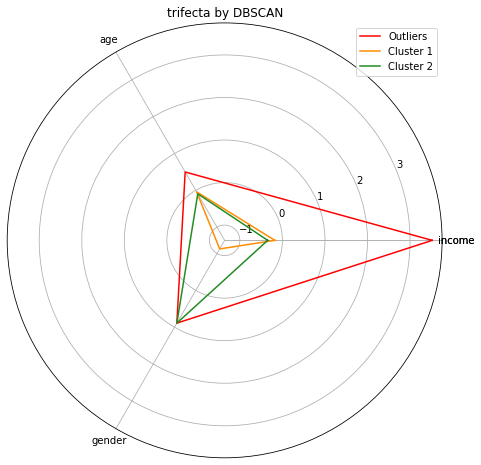

 3    189
 0    164
 1    139
 4    100
 2     39
-1     33
 6     27
 5     23
dtype: int64


IndexError: list index out of range

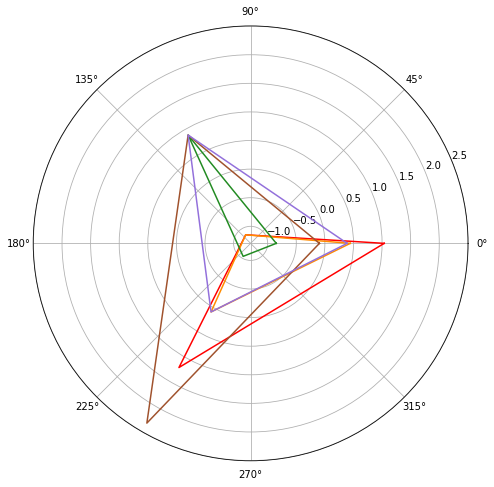

In [36]:
for i in range(len(different_data)):
    db = DBSCAN(eps=0.7,
            min_samples=12,
            metric='euclidean')

    y_db = db.fit_predict(different_data[i].values)
    print(pd.DataFrame(y_db).value_counts())
    radar_plot(different_data[i], y_db, f"{str(labels[i])} by DBSCAN")
    

### Bar Charts

Clusters are colored, inputted based on percentage of total data points they capture

In [ ]:
#concatinate clustering and data
db_data = pd.concat([customers_normal,pd.DataFrame(y_db)], axis=1)
db_data  = db_data.rename(columns= {0: 'cluster'})

db_data.value_counts('cluster')

In [ ]:
db_clustered = db_data.groupby('cluster').mean()
db_clustered

In [ ]:
db_clustered.columns

In [ ]:
x = np.arange(len(db_clustered.columns))
width = 0.35
labels = list(db_clustered.columns)

#sample plot
fig, ax = plt.subplots(figsize=(10,5))

rects1 = ax.bar(x - 2*(width/3), db_clustered.loc[0].values, width/2, label='Cluster 1')
rects2 = ax.bar(x, db_clustered.loc[1].values, width/2, label='Cluster 2')
rects3 = ax.bar(x + 2*(width/3), db_clustered.loc[-1].values, width/2, label='Outliers')

ax.set_ylabel('Mean')
ax.set_title('Mean of Cluster by input feature')
ax.set_xticks(x)
ax.set_xticklabels( (db_clustered.columns) )


ax.legend()
fig.tight_layout()

In [ ]:
import statistics

In [ ]:
hc_data = pd.concat([customers_normal,pd.DataFrame(y_hc)], axis=1)
hc_data  = hc_data.rename(columns= {0: 'cluster'})

hc_clustered = hc_data.groupby('cluster').median()
hc_clustered.head()

In [ ]:
x = np.arange(len(hc_clustered.columns))
width = 0.25
labels = list(hc_clustered.columns)

#sample plot
fig, ax = plt.subplots(figsize=(10,5))

rects1 = ax.bar(x - 2*(width/4), hc_clustered.loc[0].values, width/4, label='Cluster 1')
rects2 = ax.bar(x - (width/4), hc_clustered.loc[1].values, width/4, label='Cluster 2')
rects3 = ax.bar(x, hc_clustered.loc[2].values, width/4, label='Cluster 3')
rects4 = ax.bar(x + (width/4), hc_clustered.loc[2].values, width/4, label='Cluster 4')
rects5 = ax.bar(x + 2*(width/4), hc_clustered.loc[2].values, width/4, label='Cluster 5')

ax.set_ylabel('Mean')
ax.set_title('Mean of Cluster by input feature')
ax.set_xticks(x)
ax.set_xticklabels( (hc_clustered.columns) )


ax.legend()
fig.tight_layout()